In [1]:
import autograd
import autograd.numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from matplotlib import colors, cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from pyDOE import lhs
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky
from scipy.linalg import solve
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from src.mintGP import mintGP
from scipy.optimize import minimize, basinhopping, differential_evolution, brute
import scipy.io as sio
import copy
from src.modules.AMOGAPE import AMOGAPE
from src.modules.GENSYNDATA import *
import pyrcel as pm
import random
from scipy.stats import truncnorm
import os
%matplotlib inline

/Users/muszynski/opt/anaconda3/envs/gp_emu_test/lib/python3.10/site-packages/pyrcel/_parcel_aux_numba.py:3: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module
  from numba.pycc import CC


## Apply to pyrcel data: X={draft velocity, aerosol concentration}; Y={parcel supersaturation}

In [2]:
def model(X):
    X_size = X.shape
    print('model input size:', X_size)
    print('X', X)

    onedim_output = []
     
    # Input params
    V = X[0][0]
    AC = X[0][1]
        
    # Fixed
    P0 = 77500. # Pressure, Pa
    T0 = 274.   # Temperature, K
    S0 = -0.02  # Supersaturation, 1-RH (98% here)
    
    sulfate =  pm.AerosolSpecies('sulfate', pm.Lognorm(mu=0.015, sigma=1.6, N=AC),
                                 kappa=0.54, bins=200)
    
    initial_aerosols = [sulfate]
        
    dt = 1.0 # timestep, seconds
    t_end = 250./V # end time, seconds... 250 meter simulation
        
    model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
    parcel_trace, aerosol_traces = model.run(t_end, dt, solver="cvode")
                
    s = parcel_trace['wc'].to_numpy(dtype='float64')
    mu = np.mean(s)
    #onedim_output.append(mu)
    #arr = np.expand_dims(s, axis=1)
    #print('onedim_output', arr.shape)
    #onedim_output.append(np.mean(arr))
    
    tmp = np.array([mu])
    out = np.expand_dims(tmp, axis=1)
    print('model output size', out.shape)
        
    return out

def pyrcel_model(X):

    X_size = X.shape
    print(X_size)

    onedim_output = []
    
    for pv in X:
        print('x1,x1:',pv)
        
        # Input params
        V = pv[0]
        AC = pv[1]
        
        # Fixed
        P0 = 77500. # Pressure, Pa
        T0 = 274.   # Temperature, K
        S0 = -0.02  # Supersaturation, 1-RH (98% here)
    
        sulfate =  pm.AerosolSpecies('sulfate',
                                 pm.Lognorm(mu=0.015, sigma=1.6, N=AC),
                                 kappa=0.54, bins=200)
    
        initial_aerosols = [sulfate]
        
        dt = 1.0 # timestep, seconds
        t_end = 250./V # end time, seconds... 250 meter simulation
        
        model = pm.ParcelModel(initial_aerosols, V, T0, S0, P0, console=False, accom=0.3)
        parcel_trace, aerosol_traces = model.run(t_end, dt, solver="cvode")
                
        s = parcel_trace['wc'].to_numpy(dtype='float64')
        mu = np.mean(s)
        onedim_output.append(mu)
        #arr = np.expand_dims(s, axis=1)
        #print('onedim_output', arr.shape)
        #onedim_output.append(np.mean(arr))
    
    tmp = np.array(onedim_output)
    out = np.expand_dims(tmp, axis=1)
    print(out.shape)
        
    return out

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def gen_input_samples(M):
    
    # Input params
    #V updraft speed, m/s
    #AC aerosol concentration

    V = []
    AC = []

    xV = get_truncated_normal(mean=2, sd=2, low=1, upp=20)
    V = xV.rvs(M)

    xAC = get_truncated_normal(mean=8, sd=2, low=50, upp=150)
    AC = xAC.rvs(M)
    
    return np.vstack((V,AC)).T
    
    '''
    for i in range(0,M):
        V.append(random.randrange(1,20))
        #AC.append(random.randrange(1,20))
        AC.append(random.randrange(250,850))
    
    return np.array([V,AC]).T
    '''

def load_data(name):
    npz = np.load(name)
    Xt = npz['arr_0']
    Yt = npz['arr_1']
    return Xt,Yt

def lhs_generate_input_data(lims, n, dim=2):
    diffs = np.diff(lims)
    Xt = lhs(dim, n)*diffs.T + lims[:,0].T 
    return Xt

def plot_all(limitscale):
    
    fig = plt.figure(figsize=[18,8])

    #===============
    # X data
    #===============
    ax = fig.add_subplot(1, 3, 1)
    ax.scatter(amo.data['X'][:,0], amo.data['X'][:,1], alpha=0.2, c='green')
    ax.scatter(Xt[:,0], Xt[:,1], alpha=1, s=50, c='red')
    ax.set_ylabel(name_param1), ax.set_xlabel(name_param2)
    ax.set_xlim(lims[0]), ax.set_ylim(lims[1])
    ax.set_title("Input data")
    
    #===============
    # Fit
    #===============
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    
    M = 50; 
    grid0 = np.linspace(lims[0][0],lims[0][1],M).reshape(M,1); 
    grid1 = np.linspace(lims[1][0],lims[1][1],M).reshape(M,1);
    XX1,XX2 = np.meshgrid(grid0,grid1)
    
    # amo.emudict['emu0'] I will have many emulator if P >= 2 and need to change 'emuXXX'.
    Z = [[amo.emudict['emu0'].predict( np.array([XX1[i,j], XX2[i,j] ]).reshape(1,2) )[0,0] for i in range(M)] for j in range(M)]
    Z = np.array(Z).T
    
    #ax.plot_surface(XX1, XX2, Z, rstride=1, cstride=1, alpha=0.3, cmap='jet')
    ax.plot_surface(XX1, XX2, Z, rstride=1, cstride=1, alpha=0.3)
    #ax.scatter3D(XX1, XX2, Z, marker='.', alpha=0.4, c='r')
    ax.set_ylabel(name_param1), ax.set_xlabel(name_param2) 
    ax.set_zlabel(name_out_var, labelpad=1.), 
    
    #===============
    #  Acquisition function
    #===============
    ax = fig.add_subplot(1, 3, 3)
    
    M = 30
    lim0 = np.linspace(lims[0][0],lims[0][1],M)
    lim1 = np.linspace(lims[1][0],lims[1][1], M)
    x0, x1 = np.meshgrid(lim0, lim1)
    ack = [[ np.float64( acq(np.array([[ x0[i, j], x1[i, j] ]])).item() )
            for i in range(M)] for j in range(M)]
    ack = np.array(ack).T
    #print('ACK', ack)
    im=ax.imshow(ack, origin='lower',extent=[lims[0][0],lims[0][1],lims[1][0],lims[1][1]], interpolation='gaussian', aspect='auto')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    #cax = fig.add_axes([0.67, 0.1, 0.5, 0.05])
    #fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax.set_ylabel(name_param1), ax.set_xlabel(name_param2) 
    ax.set_title("Acqusition function A(x)")
    
    # Update
    new = amo.update(limitscale, acq)
    print( amo.emudict['emu0'].likelihood_variance )
    ax.scatter(new[0],new[1],s=70,color='magenta',alpha=1)
    
    print('RMSE: ',amo.test(Xt,Yt))
    plt.show()

def plot_fit(amo, Xt, lims, name_param1, name_param2, name_out_var):
    
    fig = plt.figure(figsize=[12,8])

    #===============
    # X data
    #===============
    ax = fig.add_subplot(1, 3, 1)
    ax.scatter(amo.data['X'][:,0], amo.data['X'][:,1], alpha=0.2, c='green')
    ax.scatter(Xt[:,0], Xt[:,1], alpha=1, s=30, c='red')
    ax.set_ylabel(name_param1), ax.set_xlabel(name_param2)
    ax.set_xlim(lims[0]), ax.set_ylim(lims[1])
    ax.set_title("Input data")
    
    #===============
    # Fit
    #===============
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    
    M = Xt.shape[0]; 
    grid0 = np.linspace(lims[0][0],lims[0][1],M).reshape(M,1); 
    grid1 = np.linspace(lims[1][0],lims[1][1],M).reshape(M,1);
    XX1,XX2 = np.meshgrid(grid0,grid1)
    
    # amo.emudict['emu0'] I will have many emulator if P >= 2 and need to change 'emuXXX'.
    Z = [[amo.emudict['emu0'].predict( np.array([XX1[i,j], XX2[i,j] ]).reshape(1,2) )[0,0] for i in range(M)] for j in range(M)]
    Z = np.array(Z).T

    #ax.plot_surface(XX1, XX2, Z, rstride=1, cstride=1, alpha=0.3, cmap='jet')
    ax.plot_surface(XX1, XX2, Z, rstride=1, cstride=1, alpha=0.3)
    #ax.scatter3D(XX1, XX2, Z, marker='.', alpha=0.4, c='r')

    #am1,am2 = np.meshgrid(amo.data['X'][:,0], amo.data['X'][:,1])
    #ax.scatter3D(am1, am2,  alpha=1, s=30, c='red')

    ax.set_ylabel(name_param1), ax.set_xlabel(name_param2) 
    ax.set_zlabel(name_out_var, labelpad=1.), 
    plt.show()

In [3]:
n_exp = 52
name_param1 = 'Total number concentration [1/cm^3]'
name_param2 = 'Updraft speed [m/s]'
name_out_var = 'Supersaturation (1-RH) [%]'
lims = np.array([[0.5,6],[800,1000]])
N = 3

exp_setup = ['exp', str(n_exp), 'XY', str(N), 'data', '.npz']
exp_name = '_'.join(exp_setup)
print(exp_name)

if os.path.isfile('./'+exp_name):
    Xt, Yt = load_data(exp_name)
    print('loaded data...', Xt.shape, Yt.shape)
else:
    Xt = lhs_generate_input_data(lims, N, dim=2)
    print(Xt)
    Yt = pyrcel_model(Xt)
    np.savez(exp_name, Xt, Yt)
    print('generated data...', Xt.shape, Yt.shape)

exp_52_XY_3_data_.npz
loaded data... (3, 2) (3, 1)


In [4]:
Xt

array([[  3.37445792, 825.42877657],
       [  1.3529046 , 988.16945022],
       [  5.95434949, 913.54751462]])

In [5]:
Xt[:,0]

array([3.37445792, 1.3529046 , 5.95434949])

In [6]:
np.mean(Xt[:,0])

3.5605706704121123

In [7]:
# Input dimension
D=2
#Output dimension
P=1

#means=np.array([3.5,940]); stdevs=np.array([1.5,855])
means=np.array([np.mean(Xt[:,0]),np.mean(Xt[:,1])]); stdevs=np.array([np.std(Xt[:,0]),np.std(Xt[:,1])])
print(means, stdevs)

startdata={}
startdata['X']=Xt
startdata['Y']=Yt #*1000 # I need to scale this and the output of model(x), but I forgot to do that.

amo = AMOGAPE(model, D=D, P=P, means=means, stdevs=stdevs, inputlimits=lims, startdata=startdata)
#acq = amo.A_add_D_add_G
acq = amo.A_prod_D_prod_G

[  3.56057067 909.04858047] [ 1.88313608 66.51472028]


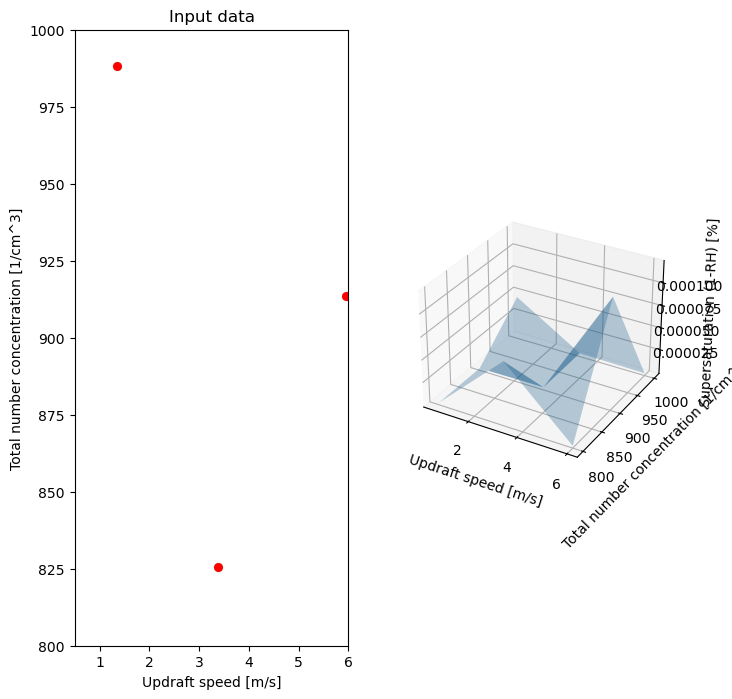

In [8]:
plot_fit(amo, Xt, lims, name_param1, name_param2, name_out_var)

In [9]:
limitscale = 1.0
for run in range(10):    
    # Update
    new = amo.update(limitscale, acq)
    print( amo.emudict['emu0'].likelihood_variance )
    print('RMSE: ',amo.test(Xt,Yt))

LIM: [[0.]
 [0.]]
negA <function AMOGAPE.update.<locals>.<lambda> at 0x7facc08adb40>
sol x: [  4.82152322 908.16375699]
model input size: (1, 2)
X [[  4.82152322 908.16375699]]


/Users/muszynski/opt/anaconda3/envs/gp_emu_test/lib/python3.10/site-packages/pyrcel/integrator.py:30: UserWarning: Could not import odespy package; invoking the 'lsoda' or 'lsode' options will fail!
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


model output size (1, 1)
DIV: 0.9587706850410664
GEO: 8.1970167205665e-05
{4: {'G': 8.1970167205665e-05, 'D': 0.9587706850410664, 'lengthscale': [1.3172913479958084], 'likelihood_sigma': [1e-09]}}
1e-09
RMSE:  3.086301970353528e-13
LIM: [[0.]
 [0.]]
negA <function AMOGAPE.update.<locals>.<lambda> at 0x7facf482ef80>
sol x: [  1.28154276 876.13991226]
model input size: (1, 2)
X [[  1.28154276 876.13991226]]
model output size (1, 1)
DIV: 0.6272350869189837
GEO: 2.4763996490763322e-05
{4: {'G': 8.1970167205665e-05, 'D': 0.9587706850410664, 'lengthscale': [1.3172913479958084], 'likelihood_sigma': [1e-09]}, 5: {'G': 2.4763996490763322e-05, 'D': 0.6272350869189837, 'lengthscale': [1.7633921383500561], 'likelihood_sigma': [1e-09]}}
1e-09
RMSE:  4.934996256428773e-13
LIM: [[0.]
 [0.]]
negA <function AMOGAPE.update.<locals>.<lambda> at 0x7facc1885000>
sol x: [  4.04799026 987.05348241]
model input size: (1, 2)
X [[  4.04799026 987.05348241]]
model output size (1, 1)
DIV: 0.25048688484878556
GEO:

LIM: [[0.]
 [0.]]
negA <function AMOGAPE.update.<locals>.<lambda> at 0x7fad00a57eb0>
sol x: [  4.52776209 946.46407604]
model input size: (1, 2)
X [[  4.52776209 946.46407604]]
model output size (1, 1)
DIV: 0.07526659700352878
GEO: 1.0639617247010839e-05
{4: {'G': 8.1970167205665e-05, 'D': 0.9587706850410664, 'lengthscale': [1.3172913479958084], 'likelihood_sigma': [1e-09]}, 5: {'G': 2.4763996490763322e-05, 'D': 0.6272350869189837, 'lengthscale': [1.7633921383500561], 'likelihood_sigma': [1e-09]}, 6: {'G': 3.868887558452229e-06, 'D': 0.25048688484878556, 'lengthscale': [1.971989429539652], 'likelihood_sigma': [1e-09]}, 7: {'G': 1.0757422256822638e-05, 'D': 0.05210444528767555, 'lengthscale': [1.445374259074489], 'likelihood_sigma': [1e-09]}, 8: {'G': 1.1248512616391051e-05, 'D': 0.2336585622190176, 'lengthscale': [0.931767766332403], 'likelihood_sigma': [1e-09]}, 9: {'G': 2.8993785098903395e-05, 'D': 0.43204717088283096, 'lengthscale': [0.6161441928239085], 'likelihood_sigma': [1e-09]}

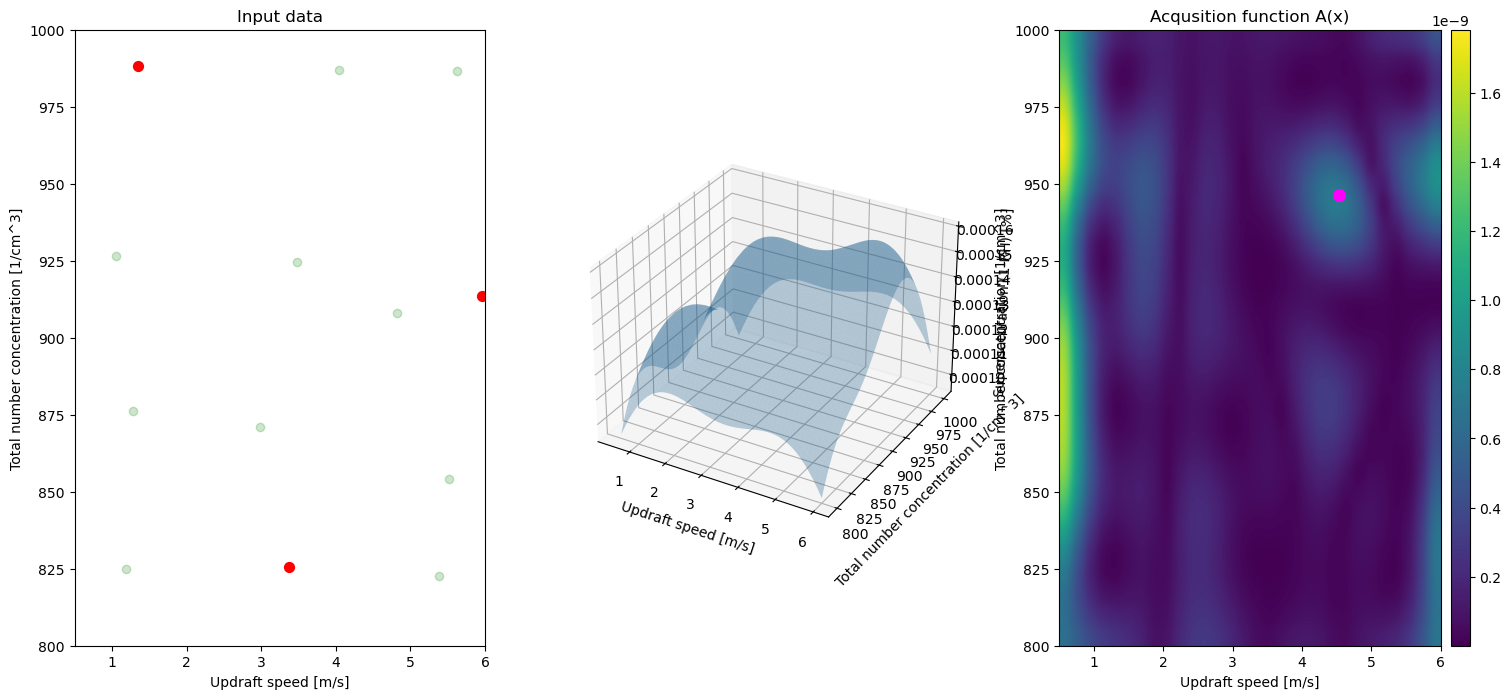

In [10]:
plot_all(limitscale)

In [11]:
amo.data['X'].shape

(14, 2)

In [12]:
means=np.array([np.mean(Xt[:,0]),np.mean(Xt[:,1])]); stdevs=np.array([np.std(Xt[:,0]),np.std(Xt[:,1])])
print(means, stdevs)

[  3.56057067 909.04858047] [ 1.88313608 66.51472028]


In [13]:
amo.means = np.array([np.mean(amo.data['X'][:,0]),np.mean(amo.data['X'][:,1])]); 
amo.stdevs = np.array([np.std(amo.data['X'][:,0]),np.std(amo.data['X'][:,1])])
print(amo.means, amo.stdevs)

[  3.61313541 903.97080356] [ 1.7366146  57.95942879]
